the mean position of the cloud of atoms moves because of the gravity with the motion equation
$$ \bar{X} (t) = - \frac{1}{2}g t^2 $$

if we assume that the cloud is distribuited as a gaussian, and that the velocity follow the bolzman distribution the radius of the mot will evolve with 
$$ \sigma (t) = \sqrt{\sigma_0^2 + \left(\frac{K_b T}{m}\right)t^2} $$

see here -> [https://arxiv.org/pdf/physics/9902072.pdf]

putting the phisical vaulue we get the following

In [16]:
import scipy.special as sps
import scipy.constants as scc
import numpy as np
import matplotlib.pyplot as plt

In [17]:
radius_0 = 40 * 10**-6# m
T = 100 * 10**-6 # K
m = 1.41810133E-25 # kg
g = 9.8 # m/s^2
kb = scc.Boltzmann
def radius(t):
    new_radius = np.sqrt(radius_0**2 + (kb*T/m)*t**2)
    return new_radius
def gravity_pos(t):
    return -0.5*g*t**2

In [18]:
ts = np.linspace(0,40*10**-3, 1000)
radiuses = radius(ts)
means = gravity_pos(ts)

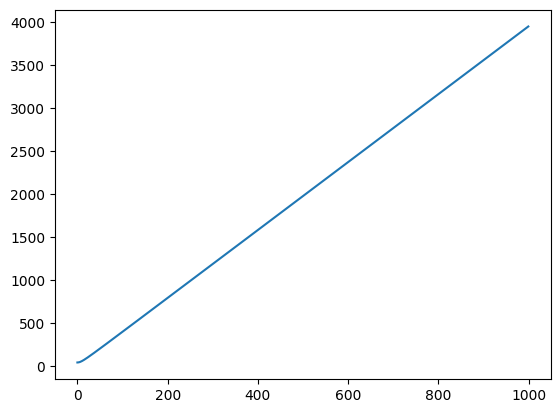

In [19]:
plt.plot(radiuses*10**6)
plt.show()

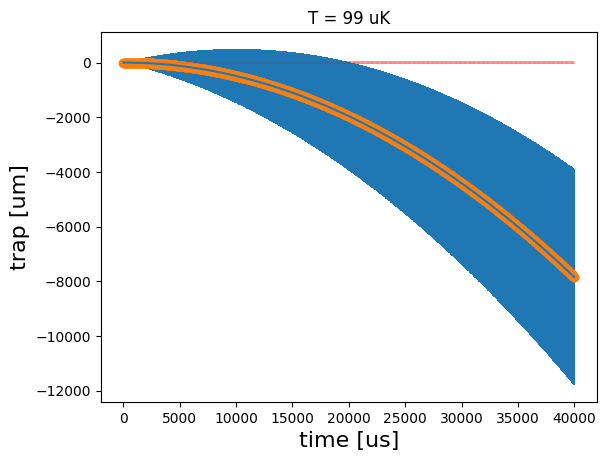

In [20]:
plt.errorbar(ts*10**6, np.zeros(len(means)), np.ones(len(means))*40 , c="red", marker=" ", alpha=0.1)

plt.errorbar(ts*10**6, means*10**6, radiuses*10**6)
plt.plot(ts*10**6, means*10**6, "o")

plt.title("T = %d uK" %(T*10**6))
plt.xlabel("time [us]", fontsize = 16)
plt.ylabel("trap [um]", fontsize = 16)

plt.show()

## FIT model

One can assume that at the beginning the dipolar trap is alligned with the center of the MOT.
So, if one assume a gaussian distribution for the MOT local density, and that the fall is simpy $-gt^2$, get the following fit model.

$$ N(t) = \frac{N(0)}{\sqrt{2\pi \sigma^2(t)}} e^{-\frac{(gt^2/2)^2}{2 \sigma^2(t)}} $$

where 

$$ \sigma^2 (t) = \sigma_0^2 + \left(\frac{K_b T}{m}\right)t^2 $$

In [21]:
def sigma_2(t, sigma_0):
    return sigma_0**2 + (kb*T/m) * t**2

def fit_fun(t, T, r_0, z_0):
    return np.exp(((g*t**2)/2)**2/(2*sigma_2(t, r_0)))/( (2*np.pi*sigma_2(t, r_0)) * np.sqrt(2*np.pi*sigma_2(t, z_0)))   # *    (2*np.pi* (r_0)**2 )**(3/2)

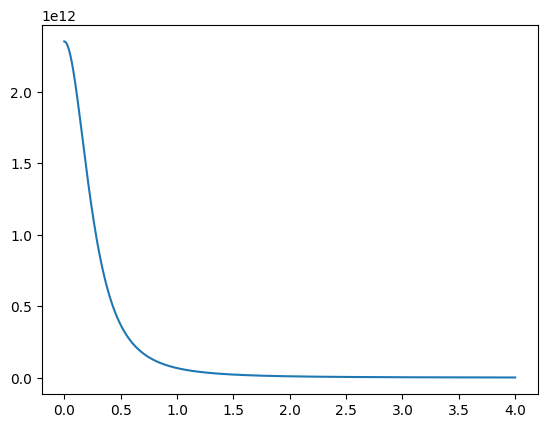

In [22]:
ts = np.linspace(0,4*10**-3, 1000)
T = 90 * 10**-6 # K
r_0 = 30 * 10**-6

N_t = fit_fun(ts, T, r_0, r_0)

plt.plot(ts*10**3, N_t)
#plt.yscale("log")
plt.show()

## FIT model considering the 3 spatial directions

One can assume that at the beginning the dipolar trap is alligned with the center of the MOT.
So, if one assume a gaussian distribution for the MOT local density, and that the fall is simpy $-gt^2$, get the following fit model.

$$ N(t) = \frac{N(0)}{(2\pi \sigma^2(t))^\frac{3}{2}} e^{-\frac{(gt^2/2)^2}{2 \sigma^2(t)}} $$

where 

$$ \sigma^2 (t) = \sigma_0^2 + \left(\frac{K_b T}{m}\right)t^2 $$

### second model
considering that the radial radius is different to the longitudinal radius

$$ N(t) = \frac{N(0)}{(2\pi)^\frac{3}{2} \sigma_r^2(t) \sqrt{\sigma_z^2(t)}} e^{-\frac{(gt^2/2)^2}{2 \sigma_r^2(t)}} $$

Where

$$ \sigma_z^2 = \frac{k_b T w_0^2 z_R^2}{2 \alpha} \ ; \  \sigma_r^2 = \frac{k_b T w_0^4}{2 \alpha} \ ; \  z_R = \frac{\pi w_0^2}{\lambda} $$
$$ \alpha = \frac{3 c^2 \Gamma P}{\omega_0^3 \Delta} $$

$$ \sigma_z^2 = \sigma_r^2 \frac{z_R^2}{w_0^2} = \sigma_r^2 \frac{\pi^2 w_0^2}{\lambda^2} $$

In [23]:

class dipolar_trap:
    def __init__(self, power, waist_0, Temperature) -> None:
        self.waist_0 = waist_0 # [m]
        self.power = power # [W]
        self.T = Temperature # [K]
        self.rubidium_mass = 1.41810133E-25 # [kg]
        self.Delta = -2*np.pi*27e12 # [Hz]
        self.omega_0 = 2*np.pi*377e12 # [Hz]
        self.Gamma = scc.e**2*self.omega_0**2/(6*np.pi*scc.epsilon_0*scc.m_e*scc.c**3)
        self.alpha = 3*scc.c**2 * self.Gamma * self.power / (self.omega_0**3 * abs(self.Delta))
        self.wavelenght = 840e-9 # [m]
        self.z_R = np.pi*waist_0**2/self.wavelenght # [m]
        self.var_r_0 = scc.Boltzmann * self.T * self.waist_0**4 / (2*self.alpha)
        self.var_z_0 = self.var_r_0 * np.pi**2 * self.waist_0**2 / self.wavelenght**2
        pass

    def get_wz(self, z):
        """ 
        returns the waist long the longitudinal axis (z)
        """
        return self.waist_0*np.sqrt(1+(z/self.z_R)**2)

    def I(self, z, r):
        """ 
        returns the intensity on the beam in a position r(radial), z(longitudinal).
        """
        return 2*self.power*np.exp(-2*r**2/(self.get_wz(z)**2))/(np.pi*self.get_wz(z)**2)

    def U_dip(self, z, r):
        """
        returns the potential in mK, in a given position r(radial), z(longitudinal).
        """
        return (3*np.pi*scc.c**2)/(2*self.omega_0**3) * (self.Gamma/self.Delta) * self.I(z, r) / scc.Boltzmann * 10**3

    def var_r(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_r_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2
    
    def var_z(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_z_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2

    def fit_function(self, t):
        return np.exp(((scc.g*t**2)/2)**2/(2*self.var_r(t)))/((2*np.pi)**(3/2)*self.var_r(t)*np.sqrt(self.var_z(t)))

    def fit_function_no_g(self, t):
        return 1/((2*np.pi)**(3/2)*self.var_r(t)*np.sqrt(self.var_z(t)))

In [24]:
my_trap = dipolar_trap(power, waist_0, T)

my_trap.fit_function(0)

29887691757667.81

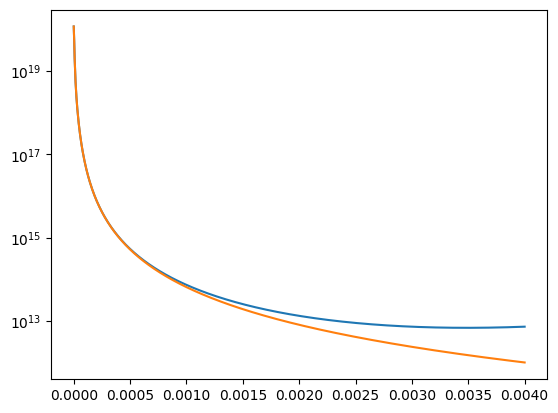

In [40]:
ts = np.linspace(0,4*10**-3, 1000)

power = 100 * 1e-3# [W]
waist_0 = 3 * 10**-6 # [m]
T = 1 * 10**-6 # [K]

my_trap = dipolar_trap(power, waist_0, T)

N_t = my_trap.fit_function(ts)
N_t_no_g = my_trap.fit_function_no_g(ts)

plt.plot(ts, N_t)
plt.plot(ts, N_t_no_g)
#plt.plot(ts, N_t_pre)
plt.yscale("log")
plt.show()

In [26]:
from scipy.integrate import quad

my_trap = dipolar_trap(power, waist_0, T)

my_trap.fit_function(0)

quad(my_trap.fit_function, 0, 0.01)

(1618532910.271865, 0.028533989284369454)

In [37]:
np.sqrt(2*scc.Boltzmann*1e-3/m)

0.4412685819027372